# Import

In [1]:
# Import package
# Outside package
import numpy as np
import scipy.io as sio
import os
from itertools import count

import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')

# Inner package
from src.RL_functions.helpers import *
from src.RL_functions.kalman import *
from src.gym_kalman.env_revised_rewards import *
from src.RL_functions.dqn_agent import *
from src.RL_functions.evaluation import *

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Import data
time_series_path = './data/HQ/DATA_h1_co_021ESAPE024.mat'
# p=os.path.dirname(r'/Users/zhanwenxin/kalman_bar_proj/kalman_bar_proj_v3/')
# os.chdir(p)

data = sio.loadmat(time_series_path)
real_timestamps = data['timestamps'].T[0]
real_observations = data['values'].T[0]

# Data processing

In [3]:
frequency = 'D'
ts_processor = DataProcessor()
resample_timestamps, resample_observations = ts_processor.resample_time_series(matlab_datenum=real_timestamps, \
                                                                            observations=real_observations, \
                                                                            frequency=frequency)

<class 'numpy.float64'>


In [4]:
# # Remove outliers
resample_observations[746:756]=np.nan
resample_observations[2730:2733]=np.nan

### Check point

================== Summary of imported time series data ==================
Most frequent time step interval:             1.0
Number of total real observations:            2789
Number of missing data in real observation:   0
Number of total resampled observations:       2892
Number of missing data in real observation:   111
Plot:


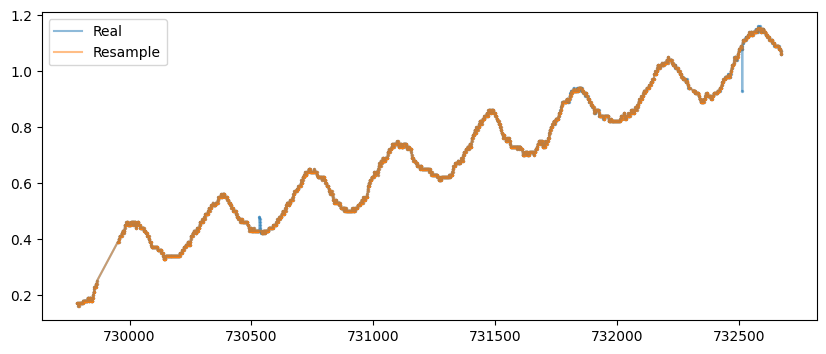

In [5]:
# Data summary
summarize_time_series(real_timestamps, real_observations, resample_timestamps, resample_observations)

# Define models

In [6]:
# Kalman filter model definition
time_step = 1           # Refer to 'Summary of imported time series data' for the reference time step
components = ['autoregressive_acceleration', 'kernel', 'ar']
hyperparameters = {'autoregressive_acceleration': {'process_error_var': 0.0, 'phi': 0.999, 'LA_process_error_var': 0.0060635**2*1e-17},
                   'kernel': {'period': 365.2422, 'kernel_length': 0.98461, 'sigma_KR0': 0, 'sigma_KR1': 0, 'n_cp':10},
                   'ar': {'phi': 0.91225, 'process_error_var': 0.0060635**2},
                   'observation': {'error': 1e-6}}
LA_var_stationary = hyperparameters['autoregressive_acceleration']['LA_process_error_var']/(1-hyperparameters['autoregressive_acceleration']['phi']**2)

x_init = {'mu': np.array([0.294, 0.00027, 0, 0, -0.035, -0.256, -0.163, 0.0281, -0.0273, 0.0258, 0.344, 0.26, -0.132, -0.0577, -0.0621]), \
          'var': np.diag([0.00531, 2.61E-12, LA_var_stationary, 0.0544, 0.0259, 0.0259, 0.0259, 0.026, 0.026, 0.0259, 0.0259, 0.0258, 0.0259, 0.0258, 6.36E-05]),\
          'var_stabilized': np.diag([0.00531, 2.61E-12, LA_var_stationary, 0.0544, 0.0259, 0.0259, 0.0259, 0.026, 0.026, 0.0259, 0.0259, 0.0258, 0.0259, 0.0258, 6.36E-05])}


In [7]:
# Reinforcement learning model definition
step_look_back = 64     # How many steps the RL agents look back in the estimate history

# Parameters relative to the trainig of Q-Network
BATCH_SIZE = 128
GAMMA = 0.99            # discount factor
EPS_START = 0.9         # greedy policy
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005             # for soft update of target parameters
LR = 1e-4               # learning rate

In [8]:
# Check the identifiability between LA and AR and get the stabilized covariance
num_steps = 10000
syn_ts = generate_time_series(components = components,\
                                time_step = time_step, \
                                hyperparameters = hyperparameters,\
                                num_steps = num_steps, \
                                x_init = x_init,\
                                insert_anomaly = False,\
                                anomaly_timesteps = [int(num_steps/2)],\
                                anomaly_LT = [1e-2]
                                )

i_ts_datasets = {
    'measurement': syn_ts['y'],
    'timestamps': syn_ts['timesteps'],
    'time_step': time_step,
    'components': components,
    'hyperparameters': hyperparameters,
    'initial_states': x_init,
}

env = KalmanInterventionEnv(render_mode=None, time_series_datasets=i_ts_datasets, step_look_back = step_look_back, \
                            hyperparameters=hyperparameters)

state, _ = env.reset(mode = 'get_stabilized_var')
for i in range(num_steps - step_look_back - 1):
    if i == 4000 + step_look_back + 1:
        action = 0
    else:
        action = 0
    state, reward, _, _, info = env.step(action)

# =============================================================================
# Update the stabilized covariance
x_init['var_stabilized'] = info['hidden_states']['var'][-1]
syn_ts = generate_time_series(components = components,\
                                time_step = time_step, \
                                hyperparameters = hyperparameters,\
                                num_steps = num_steps, \
                                x_init = x_init,\
                                insert_anomaly = False,\
                                anomaly_timesteps = [int(num_steps/2)],\
                                anomaly_LT = [1e-2]
                                )

i_ts_datasets = {
    'measurement': syn_ts['y'],
    'timestamps': syn_ts['timesteps'],
    'time_step': time_step,
    'components': components,
    'hyperparameters': hyperparameters,
    'initial_states': x_init,
}

env = KalmanInterventionEnv(render_mode=None, time_series_datasets=i_ts_datasets, step_look_back = step_look_back, \
                            hyperparameters=hyperparameters)

state, _ = env.reset(mode = 'test')

for i in range(num_steps - step_look_back - 1):
    if i == 4000 + step_look_back + 1:
        action = 0
    else:
        action = 0
    state, reward, _, _, info = env.step(action)

### Check point

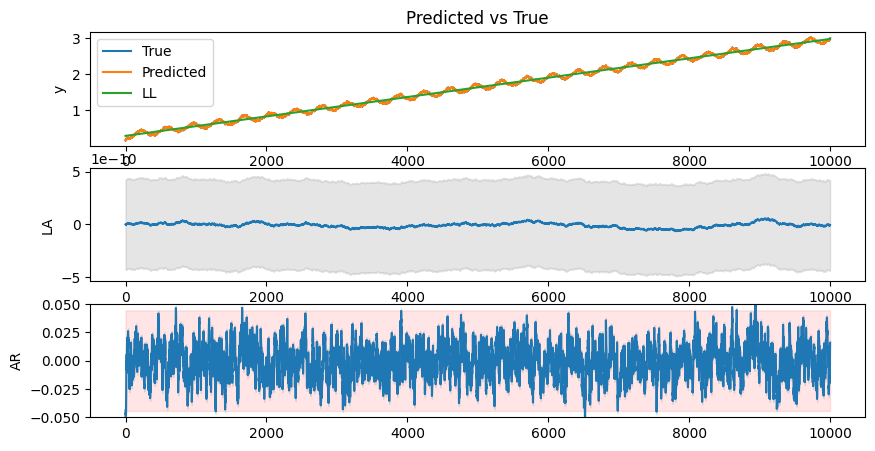

In [9]:
# Plot prediction
from matplotlib import gridspec
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(3, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
# ax3 = plt.subplot(gs[3])
# ax4 = plt.subplot(gs[4])

ax0.plot(syn_ts['timesteps'], syn_ts['y'], label='True')
# plot the standard deviation of the prediction
# ax0.fill_between(syn_ts['time'], info['y_pred']['mu'] - np.sqrt(info['y_pred']['var']),\
#                 info['y_pred']['mu'] + np.sqrt(info['y_pred']['var']), color='gray', alpha=0.2)
ax0.plot(syn_ts['timesteps'], info['y_pred']['mu'], label='Predicted')
# ax0.axvline(x=anomaly_pos, color='gray', linestyle='--')
ax0.plot(syn_ts['timesteps'], info['hidden_states']['mu'][:,0], label='LL')
# ax0.axvline(x=anomaly_pos+num_steps, color='gray', linestyle='--')
ax0.set_title('Predicted vs True')
ax0.set_ylabel('y')
# ax0.set_ylim(-5, 15)
ax0.legend()

# ax1.fill_between(syn_ts['timesteps'], np.zeros_like(syn_ts['timesteps'])-np.sqrt(LA_var_stationary), np.zeros_like(syn_ts['timesteps'])+np.sqrt(LA_var_stationary), color='red', alpha=0.1)
ax1.plot(syn_ts['timesteps'], info['hidden_states']['mu'][:,2], label='LA')
ax1.fill_between(syn_ts['timesteps'], info['hidden_states']['mu'][:,2] - np.sqrt(info['hidden_states']['var'][:,2,2]),\
                    info['hidden_states']['mu'][:,2] + np.sqrt(info['hidden_states']['var'][:,2,2]), color='gray', alpha=0.2)

ax1.set_ylabel('LA')

AR_var_stationary = hyperparameters['ar']['process_error_var']/(1-hyperparameters['ar']['phi']**2)
ax2.fill_between(syn_ts['timesteps'], np.zeros_like(syn_ts['timesteps'])-3*np.sqrt(AR_var_stationary), np.zeros_like(syn_ts['timesteps'])+3*np.sqrt(AR_var_stationary), color='red', alpha=0.1)
ax2.plot(syn_ts['timesteps'], info['hidden_states']['mu'][:,-1], label='AR')
ax2.fill_between(syn_ts['timesteps'], info['hidden_states']['mu'][:,-1] - np.sqrt(info['hidden_states']['var'][:,-1,-1]),\
                    info['hidden_states']['mu'][:,-1] + np.sqrt(info['hidden_states']['var'][:,-1,-1]), color='gray', alpha=0.2)
ax2.set_ylabel('AR')
ax2.set_ylim(-0.05, 0.05)

plt.show()

coeff_one_episode= np.array(info['hidden_states']['var'][:,2,-1])/np.sqrt(info['hidden_states']['var'][:,2,2])/np.sqrt(info['hidden_states']['var'][:,-1,-1])[-1]

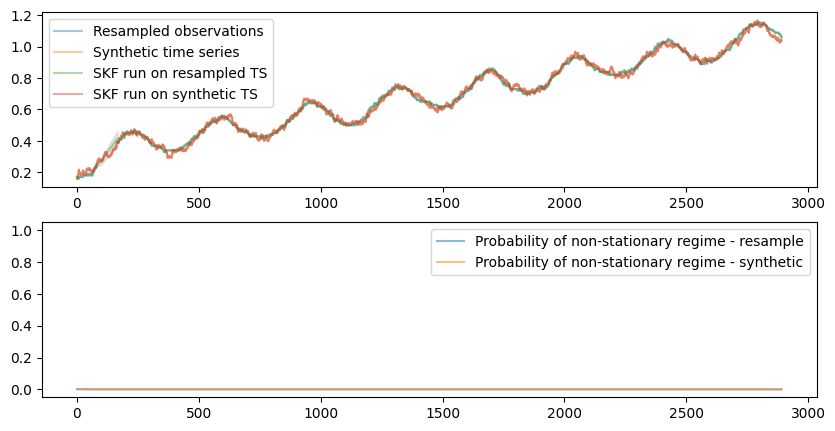

In [10]:
# Check if the KF and RL models are correctly defined
num_steps = 2892        # Refer to 'Summary of imported time series data' for the reference time step
ts_model_check = generate_time_series(components = components,\
                                      time_step = time_step, \
                                      hyperparameters = hyperparameters,\
                                      num_steps = num_steps, \
                                      x_init = x_init,\
                                      insert_anomaly = False)

prob_ns_regime, y_mu, y_var, x_mu, x_var   = SKF_check(hyperparameters, x_init, ts_model_check['timesteps'], resample_observations, time_step_interval = time_step)
prob_ns_regime_syn, y_mu_syn, y_var_syn, _, _ = SKF_check(hyperparameters, x_init, ts_model_check['timesteps'], ts_model_check['y'], time_step_interval = time_step)

from matplotlib import gridspec
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.plot(ts_model_check['timesteps'], resample_observations, label='Resampled observations', alpha=0.4)
ax0.plot(ts_model_check['timesteps'], ts_model_check['y'], label='Synthetic time series', alpha=0.4)
ax0.plot(ts_model_check['timesteps'], y_mu, label='SKF run on resampled TS', alpha=0.4)
ax0.fill_between(ts_model_check['timesteps'], y_mu - np.sqrt(y_var), y_mu + np.sqrt(y_var), color='gray', alpha=0.2)
ax0.plot(ts_model_check['timesteps'], y_mu_syn, label='SKF run on synthetic TS', alpha=0.4)
ax0.fill_between(ts_model_check['timesteps'], y_mu_syn - np.sqrt(y_var_syn), y_mu_syn + np.sqrt(y_var_syn), color='gray', alpha=0.2)
ax0.legend()

ax1.plot(ts_model_check['timesteps'], prob_ns_regime, label='Probability of non-stationary regime - resample', alpha=0.5)
ax1.plot(ts_model_check['timesteps'], prob_ns_regime_syn, label='Probability of non-stationary regime - synthetic', alpha=0.5)
ax1.set_ylim([-0.05, 1.05])
ax1.legend()

#### Kalman-gym environment check

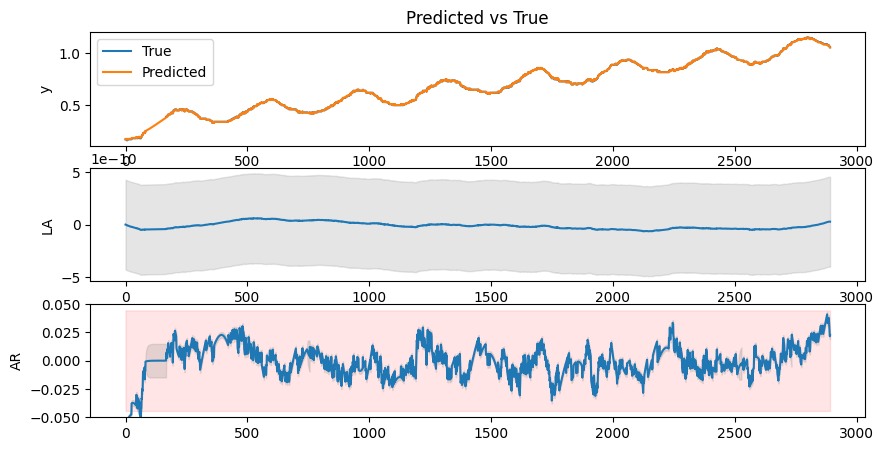

In [11]:
num_steps = len(resample_timestamps)

# Set the dataset for the environment
dummy_ts_datasets = {
            'measurement': resample_observations,
            'time_step': time_step,
            'timestamps': resample_timestamps,
            'components': components,
            'hyperparameters': hyperparameters,
            'initial_states': x_init,
        }

# Create the environment
total_reward = 0
env = KalmanInterventionEnv(render_mode=None, time_series_datasets=dummy_ts_datasets, step_look_back = step_look_back, hyperparameters=hyperparameters, smoothing_length=0)

state, info = env.reset(mode = 'test')
intervention_index =[]
intervention_taken = False
AR_std_stationary = np.sqrt(hyperparameters['ar']['process_error_var']/(1-hyperparameters['ar']['phi']**2))
if step_look_back == 64:
    seg_len = 8
for i in range(num_steps - step_look_back - 1):
    # state = torch.tensor(np.hstack((state['KF_hidden_states'], intervention_taken)),\
    #                     dtype=torch.float32, device=device).unsqueeze(0)
    state = torch.tensor(state['KF_hidden_states'],\
                        dtype=torch.float32, device=device).unsqueeze(0)
    state = normalize_tensor_two_parts(state, 0, np.sqrt(LA_var_stationary),\
                                        0, AR_std_stationary, seg_len)
    action = 0

    state, reward, _, _, info = env.step(action)

# print(f'Total reward: {total_reward}')

# Plot prediction
from matplotlib import gridspec
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(3, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

ax0.plot(ts_model_check['timesteps'], resample_observations, label='True')
ax0.plot(ts_model_check['timesteps'], info['y_pred']['mu'], label='Predicted')
for i in intervention_index:
    ax0.axvline(x=ts_model_check['timesteps'][i], color='r', linestyle='--')
ax0.set_title('Predicted vs True')
ax0.set_ylabel('y')
ax0.legend()

ax1.plot(ts_model_check['timesteps'], info['hidden_states']['mu'][:,2], label='LA')
ax1.fill_between(ts_model_check['timesteps'], info['hidden_states']['mu'][:,2] - np.sqrt(info['hidden_states']['var'][:,2,2]),\
                    info['hidden_states']['mu'][:,2] + np.sqrt(info['hidden_states']['var'][:,2,2]), color='gray', alpha=0.2)
ax1.set_ylabel('LA')

AR_var_stationary = hyperparameters['ar']['process_error_var']/(1-hyperparameters['ar']['phi']**2)
ax2.fill_between(ts_model_check['timesteps'], np.zeros_like(ts_model_check['timesteps'])-3*np.sqrt(AR_var_stationary), np.zeros_like(ts_model_check['timesteps'])+3*np.sqrt(AR_var_stationary), color='red', alpha=0.1)
ax2.plot(ts_model_check['timesteps'], info['hidden_states']['mu'][:,-1], label='AR')
ax2.fill_between(ts_model_check['timesteps'], info['hidden_states']['mu'][:,-1] - np.sqrt(info['hidden_states']['var'][:,-1,-1]),\
                    info['hidden_states']['mu'][:,-1] + np.sqrt(info['hidden_states']['var'][:,-1,-1]), color='gray', alpha=0.2)
ax2.set_ylabel('AR')
ax2.set_ylim(-0.05, 0.05)
plt.show()

# Training

In [12]:
training_episodes = 200
anomaly_range = [-0.001, 0.001]
abnormal_ts_percentage = 0.5
plot_samples = True # Plot the samples where the agent identifies two anomalies

In [13]:
# Create environment
i_ts_datasets = {
    'measurement': ts_model_check['y'],
    'timestamps': ts_model_check['timesteps'],
    'time_step': time_step,
    'components': components,
    'hyperparameters': hyperparameters,
    'initial_states': x_init,
}

env = KalmanInterventionEnv(render_mode=None, time_series_datasets=i_ts_datasets, \
                            step_look_back = step_look_back, hyperparameters=hyperparameters, \
                            smoothing_length=0)
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset(mode = 'train')
n_observations = len(state['KF_hidden_states'])

print('================== Environment information ==================')
print('Number of actions:', n_actions)
print('Number of observations:', n_observations)

================== Environment information ==================
Number of actions: 2
Number of observations: 16


<Figure size 640x480 with 0 Axes>

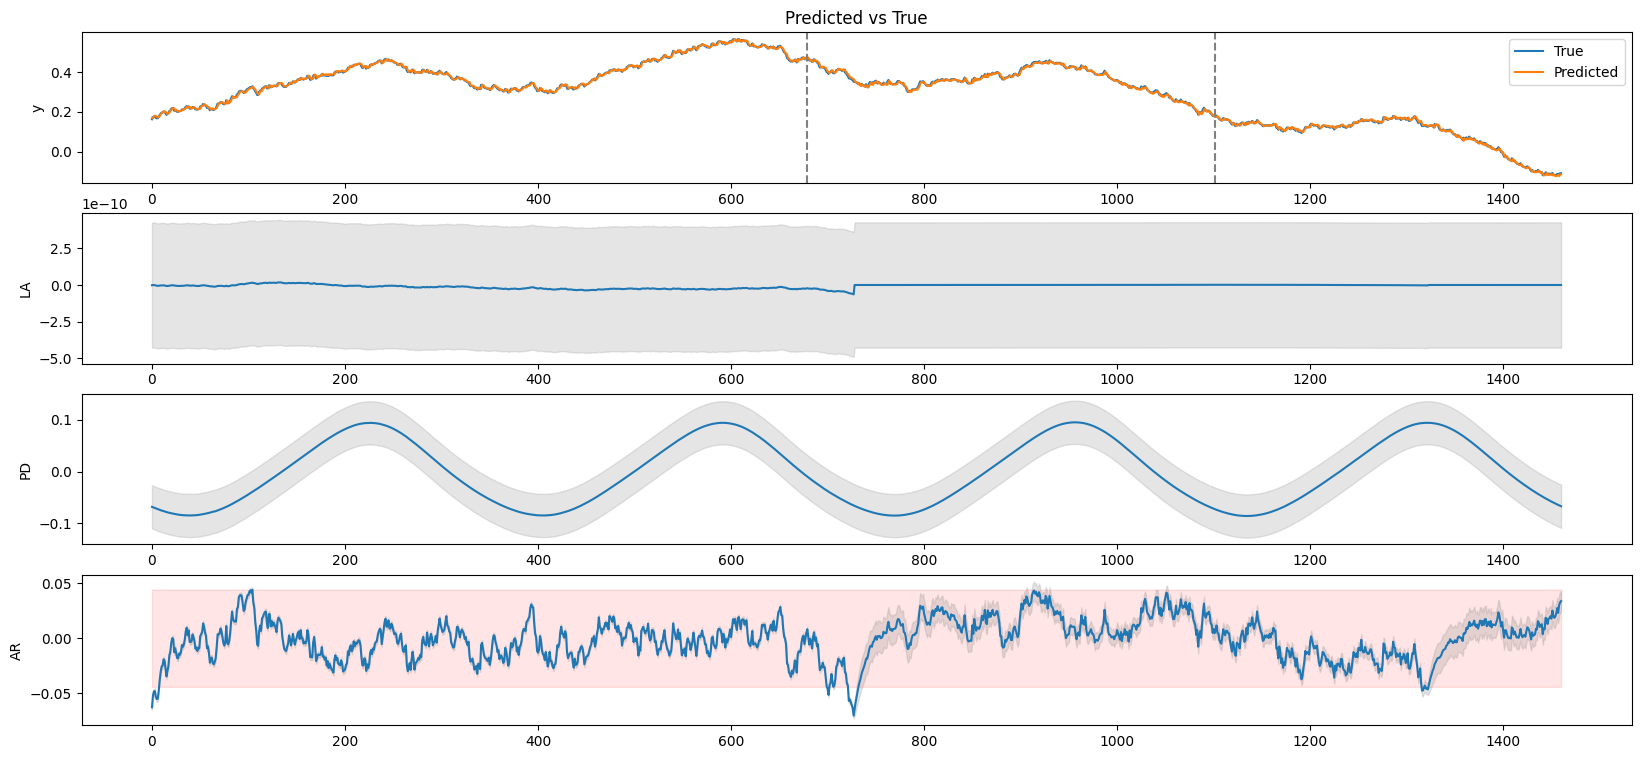

KeyboardInterrupt: 

In [14]:
# Train the agent
timeseries_duration = 4 * 365.2422
num_steps_per_episode = int(np.round(timeseries_duration/time_step))

agent = DQN_agent(n_observations, n_actions, device, LR, GAMMA)
agent.train(training_episodes, step_look_back, num_steps_per_episode, \
            components, time_step, hyperparameters, x_init, \
            abnormal_ts_percentage, anomaly_range, \
            BATCH_SIZE, TAU, plot_samples)

# Testing

### Statistical comparison RL v.s. SKF

In [15]:
num_steps = len(resample_timestamps)
anomaly_magnitudes, f1t_all, f1t_skf_all, = f1t_evaluation(\
                                                take_action = agent.select_action, \
                                                anomaly_magnitudes = [0.00, 0.0001, 0.0002, 0.0003, 0.0005, 0.001, 0.002],\
                                                components = components, hyperparameters = hyperparameters, x_init = x_init, \
                                                device = device, num_steps = num_steps, time_step = time_step, \
                                                use_real_data = True, real_timestamps = resample_timestamps, real_observations = resample_observations, \
                                                reps = 50, compare_with_skf = False, step_look_back = step_look_back)

  0%|          | 0/7 [00:31<?, ?it/s]


KeyboardInterrupt: 

In [16]:
plt.plot(anomaly_magnitudes, f1t_all, label = 'RL-based')
plt.plot(anomaly_magnitudes, f1t_skf_all, label = 'SKF1, z12=1e-7')
# Set the digits after the decimal point in the x-axis
from matplotlib.ticker import FormatStrFormatter
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0e'))
# set x axis begin from 0
plt.xlim(0, 0.002)
plt.xlabel('Anomaly magnitude')
plt.ylabel('F1t score')
plt.ylim(0,1)
plt.legend()
plt.show()

NameError: name 'anomaly_magnitudes' is not defined

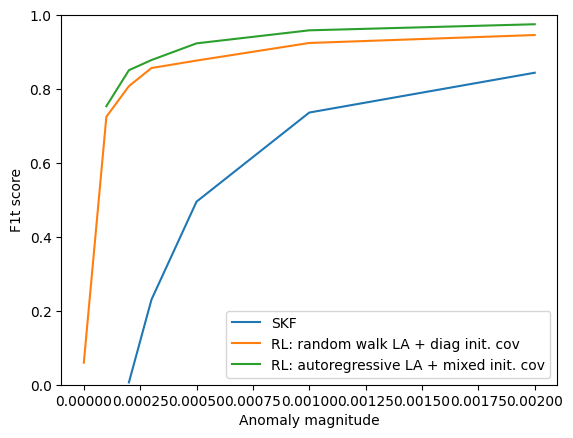

In [ ]:
# Compare f1t curve
anomaly_magnitudes = [0.00, 0.0001, 0.0002, 0.0003, 0.0005, 0.001, 0.002]
true_positive_all_skf =  [0, 0, 5, 50, 50, 50, 50]
false_positive_all_skf = [0, 0, 0, 0, 0, 0, 0]
false_negative_all_skf = [50, 50, 45, 0, 0, 0, 0]
penalty_ratio_all_skf =  [np.nan, np.nan, 0.034247, 0.230192, 0.49537, 0.73641, 0.844137]

true_positive_all_rl0 =  [2, 47, 46, 50, 48, 49, 49]
false_positive_all_rl0 = [1, 3, 4, 0, 2, 1, 1]
false_negative_all_rl0 = [47, 0, 0, 0, 0, 0, 0]
penalty_ratio_all_rl0 =  [0.77547, 0.74815, 0.84295, 0.85685, 0.89530, 0.93408, 0.95578]

true_positive_all_rl1 =  [0, 50, 50, 49, 50, 50, 50]
false_positive_all_rl1 = [0, 0, 0, 1, 0, 0, 0]
false_negative_all_rl1 = [50, 0, 0, 0, 0, 0, 0]
penalty_ratio_all_rl1 =  [np.nan, 0.75355, 0.85094, 0.88737, 0.92361, 0.95887, 0.97530]

from src.RL_functions.helpers import *
def compute_f1t_once(true_positive, false_positive, false_negative, penalty_ratio):
    if true_positive == 0:
        f1 = 0
    else:
        precision = true_positive/(true_positive+false_positive)
        recall = true_positive/(true_positive+false_negative)
        f1 = 2*precision*recall/(precision+recall)

    f1t = f1*penalty_ratio
    return f1t

# Compute the f1 score
f1t_skf = []
f1t_rl0 = []
f1t_rl1 = []
for i in range(len(anomaly_magnitudes)):
    f1t = compute_f1t_once(true_positive_all_skf[i], false_positive_all_skf[i], false_negative_all_skf[i], penalty_ratio_all_skf[i])
    f1t_skf.append(f1t)
    f1t = compute_f1t_once(true_positive_all_rl0[i], false_positive_all_rl0[i], false_negative_all_rl0[i], penalty_ratio_all_rl0[i])
    f1t_rl0.append(f1t)
    f1t = compute_f1t_once(true_positive_all_rl1[i], false_positive_all_rl1[i], false_negative_all_rl1[i], penalty_ratio_all_rl1[i])
    f1t_rl1.append(f1t)

plt.plot(anomaly_magnitudes, f1t_skf, label = 'SKF')
plt.plot(anomaly_magnitudes, f1t_rl0, label = 'RL: random walk LA + diag init. cov')
plt.plot(anomaly_magnitudes, f1t_rl1, label = 'RL: autoregressive LA + mixed init. cov')

plt.xlabel('Anomaly magnitude')
plt.ylabel('F1t score')
plt.ylim(0,1)
plt.legend()
plt.show()

### Time series sample

In [ ]:
def interact_Q_visualization(agent_pos = 200, seed=21, anm_mag = 5):
    anm_mag = -anm_mag/10000
    num_steps = len(resample_timestamps)
    np.random.seed(seed)

    # Randomly sample an integer between num_steps/4 and num_steps/2
    anomaly_pos = np.random.randint(int(num_steps/4), int(num_steps/2))
    anomaly_pos2 = np.random.randint(int(num_steps/4*3), int(num_steps))

    syn_ts = insert_anomalies(timestamps = resample_timestamps, observations = resample_observations, \
                                      time_step = time_step, anomaly_timesteps = [anomaly_pos, anomaly_pos2], anomaly_LT = [anm_mag, -anm_mag])

    ################################# Baseline SKF #################################
    SKF_class=SKF(syn_ts['timesteps'], syn_ts['y'])

    configuration_skf_bar = {
            "LT_sigma_w": 0,
            "LA_sigma_w": 0,
            "KR_p": 365.2422,
            "KR_ell": 0.98461,
            "KR_sigma_w": 0,
            "KR_sigma_hw": 0,
            "AR_phi": 0.91225,
            "AR_sigma_w": 0.0060635,
            "sigma_v": 0.001,
            "X_init": np.array([0.294, 0.00027, 0, 0, -0.035, -0.256, -0.163, 0.0281, -0.0273, 0.0258, 0.344, 0.26, -0.132, -0.0577, -0.0621]),
            "V_init": np.diag([0.00531, 2.61E-12, LA_var_stationary, 0.0544, 0.0259, 0.0259, 0.0259, 0.026, 0.026, 0.0259, 0.0259, 0.0258, 0.0259, 0.0258, 6.36E-05]),
            "Z_11": 0.9999999,
            "Z_22": 0.9999999,
            "pi_1": 0.999,
            "pi_2": 0.001,
            "isBounded": False,
            "BAR_gamma_value": 0,
            "sigma_12": 1e-06
            }

    SKF_class.import_configuration(configuration_skf_bar)

    prob_ns_regime, x_mu, x_var, y_mu = SKF_class.get_alarm()
    # Get the all indices where prob_ns_regime is bigger than 0.5
    skf_triggers = np.where(prob_ns_regime > 0.5)[0]

    ################################# RL #################################

    # Set the dataset for the RL environment
    dummy_ts_datasets = {
                'measurement': syn_ts['y'],
                'time_step': time_step,
                'timestamps': syn_ts['timesteps'],
                'components': components,
                'hyperparameters': hyperparameters,
                'initial_states': x_init,
            }

    # Create the environment
    total_reward = 0
    env = KalmanInterventionEnv(render_mode=None, time_series_datasets=dummy_ts_datasets, step_look_back = step_look_back, hyperparameters=hyperparameters, smoothing_length=0)

    steps_lb = env._get_look_back_time_steps(agent_pos)

    state, info = env.reset(mode = 'test')
    intervention_index =[]
    intervention_taken = False
    AR_std_stationary = np.sqrt(hyperparameters['ar']['process_error_var']/(1-hyperparameters['ar']['phi']**2))
    if step_look_back == 64:
        seg_len = 8
    for i in range(num_steps - step_look_back - 1):
        state = torch.tensor(state['KF_hidden_states'],\
                            dtype=torch.float32, device=device).unsqueeze(0)
        state = normalize_tensor_two_parts(state, 0, np.sqrt(LA_var_stationary),\
                                            0, AR_std_stationary, seg_len)
        action = agent.select_action(state, greedy=True)
        action = action.item()

        if i  == agent_pos - step_look_back:
            print('Q (s, a = no interv.):',float(agent.policy_net(state)[0, 0]))
            print('Q (s, a = interv.):',float(agent.policy_net(state)[0, 1]))

        state, reward, _, _, info = env.step(action)


        if action == 1:
            intervention_index.append(i + step_look_back + 1)
            intervention_taken = True
        total_reward += reward

    # print(f'Total reward: {total_reward}')

    # Plot prediction
    from matplotlib import gridspec
    fig = plt.figure(figsize=(20, 9))
    gs = gridspec.GridSpec(3, 1)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])


    for count, i in enumerate(skf_triggers):
        if count == 0:
            ax0.axvline(x=ts_model_check['timesteps'][i], color='b', alpha=0.05, linestyle='--', label='SKF triggers')
        else:
            ax0.axvline(x=ts_model_check['timesteps'][i], color='b', alpha=0.05,linestyle='--')

    ax0.plot(ts_model_check['timesteps'], syn_ts['y'], label='True')
    # plot the standard deviation of the prediction
    # ax0.fill_between(syn_ts['timesteps'], info['y_pred']['mu'] - np.sqrt(info['y_pred']['var']),\
    #                 info['y_pred']['mu'] + np.sqrt(info['y_pred']['var']), color='gray', alpha=0.2)
    ax0.plot(ts_model_check['timesteps'], info['y_pred']['mu'], label='Predicted')
    ax0.axvline(x=ts_model_check['timesteps'][anomaly_pos], color='gray', linestyle='--', label='Anomaly begin')
    ax0.axvline(x=ts_model_check['timesteps'][anomaly_pos2], color='gray', linestyle='--')

    for count, i in enumerate(intervention_index):
        if count == 0:
            ax0.axvline(x=ts_model_check['timesteps'][i], color='r', linestyle='--', label='RL triggers')
        else:
            ax0.axvline(x=ts_model_check['timesteps'][i], color='r', linestyle='--')
    ax0.set_title('Predicted vs True')
    ax0.set_ylabel('y')
    # ax0.set_ylim(-5, 15)
    ax0.legend()

    ax1.plot(ts_model_check['timesteps'], info['hidden_states']['mu'][:,2], label='LA')
    ax1.fill_between(ts_model_check['timesteps'], info['hidden_states']['mu'][:,2] - np.sqrt(info['hidden_states']['var'][:,2,2]),\
                        info['hidden_states']['mu'][:,2] + np.sqrt(info['hidden_states']['var'][:,2,2]), color='gray', alpha=0.2)
    for step in steps_lb:
        ax1.scatter(ts_model_check['timesteps'][step], info['hidden_states']['mu'][step,2], color='r', s=15)
    # ax2.set_ylim(-2e-6, 5e-6)
    ax1.set_ylabel('LA')

    AR_var_stationary = hyperparameters['ar']['process_error_var']/(1-hyperparameters['ar']['phi']**2)
    ax2.fill_between(ts_model_check['timesteps'], np.zeros_like(syn_ts['timesteps'])-3*np.sqrt(AR_var_stationary), np.zeros_like(syn_ts['timesteps'])+3*np.sqrt(AR_var_stationary), color='red', alpha=0.1)
    ax2.plot(ts_model_check['timesteps'], info['hidden_states']['mu'][:,-1], label='AR')
    ax2.fill_between(ts_model_check['timesteps'], info['hidden_states']['mu'][:,-1] - np.sqrt(info['hidden_states']['var'][:,-1,-1]),\
                        info['hidden_states']['mu'][:,-1] + np.sqrt(info['hidden_states']['var'][:,-1,-1]), color='gray', alpha=0.2)
    for step in steps_lb:
        ax2.scatter(ts_model_check['timesteps'][step], info['hidden_states']['mu'][step,-1], color='r', s=15)
    ax2.set_ylabel('AR')
    plt.show()

In [ ]:
import ipywidgets
ipywidgets.interact(interact_Q_visualization, agent_pos = (64, 2890, 1), seed = (0, 100, 1), anm_mag = (0, 10, 1))

ModuleNotFoundError: No module named 'ipywidgets'